In [89]:
import cobra
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 12

In [90]:
# define functions for the estiamting delta G ranges
RT = 8.31446261815324 * 10**-3 * 298.15

def parse_reaction_to_df(reaction):
    mdf = {'met_id': [], 's': [] }
    for met in reaction.metabolites:
        mdf['s'].append(reaction.metabolites[met])
        ##mdf['met_id'].append(met.id.split('_')[0])
        mdf['met_id'].append(met.id[:-2])
        
    
    mdf = pd.DataFrame(mdf)
    mdf['met_id'] = mdf['met_id'].apply(lambda x: 'bigg.metabolite:' + x)
    return mdf


def get_concentrations(x,metConc):
    if x == 'bigg.metabolite:nad':
        return 2.6e-3
    elif x == 'bigg.metabolite:nadh':
        return 8.3e-5
    elif x == 'bigg.metabolite:nadp':
        return 2.1e-6
    elif x == 'bigg.metabolite:nadph':
        return 1.2e-4
    elif x in ['bigg.metabolite:h','bigg.metabolite:h2o']:
        return 1
    else:
        return metConc
    
    
def rdf2metConcs(mdf,ub,lb):
    maxG_conc = []
    minG_conc = []
    met_lb = lb;
    met_ub = ub;

    for i,row in mdf.iterrows():
        if row.s < 0:
            minG_conc.append(get_concentrations(row.met_id,met_ub))
            maxG_conc.append(get_concentrations(row.met_id,met_lb))
        else:
            minG_conc.append(get_concentrations(row.met_id,met_lb))
            maxG_conc.append(get_concentrations(row.met_id,met_ub))

    mdf['conc_maxG'] =  maxG_conc;
    mdf['conc_minG'] =  minG_conc;
    return mdf

def dg2dir(maxDg,minDg):
    if (maxDg > 0) & (minDg < 0):
        return 'reversible'
    elif (maxDg > 0) & (minDg > 0):
        return 'irreversible (backward)'
    else:
        return 'irreversible (forward)'
    
def append_gene_set_with_free_energy_range(model,dfff,lb,ub):

    wt_coenzyme = []
    mut_coenzyme = []

    wt_max_dg = []
    wt_min_dg = []

    mut_max_dg = []
    mut_min_dg = []

    for idx,row in dfff.iterrows():
        rsub = [x for x in model.reactions if row.reaction == x.id][0]
        mdf = parse_reaction_to_df(rsub)
        mdf_mut = mdf.copy()
        if 'bigg.metabolite:nadph' in mdf['met_id'].tolist():
            wt_coenzyme.append('NADP(H)')
            mut_coenzyme.append('NAD(H)')
            mdf_mut['met_id'] = mdf_mut.met_id.replace({'bigg.metabolite:nadph': 'bigg.metabolite:nadh', 'bigg.metabolite:nadp': 'bigg.metabolite:nad'})
        else:
            wt_coenzyme.append('NAD(H)')
            mut_coenzyme.append('NADP(H)')
            mdf_mut['met_id'] = mdf_mut.met_id.replace({'bigg.metabolite:nadh': 'bigg.metabolite:nadph', 'bigg.metabolite:nad': 'bigg.metabolite:nadp'})

        mdf = rdf2metConcs(mdf,ub,lb)
        mdf_mut = rdf2metConcs(mdf_mut,ub,lb)
        wt_max_dg.append(row.deltaG_prime_m + RT * np.log(np.prod(mdf['conc_maxG'] ** mdf['s'])))
        wt_min_dg.append(row.deltaG_prime_m + RT * np.log(np.prod(mdf['conc_minG'] ** mdf['s'])))

        mut_max_dg.append(row.deltaG_prime_m + RT * np.log(np.prod(mdf_mut['conc_maxG'] ** mdf_mut['s'])))
        mut_min_dg.append(row.deltaG_prime_m + RT * np.log(np.prod(mdf_mut['conc_minG'] ** mdf_mut['s'])))
        
    dfff['wild type coenzyme'] = wt_coenzyme
    dfff['mutant coenzyme'] = mut_coenzyme

    dfff['max_deltaG (WT)'] = wt_max_dg
    dfff['min_deltaG (WT)'] = wt_min_dg

    dfff['max_deltaG (mutant)'] = mut_max_dg
    dfff['min_deltaG (mutant)'] = mut_min_dg
        
    mut_dir  = [];
    wt_dir = []
    for idx,row in dfff.iterrows():
        wt_dir.append(dg2dir(row['max_deltaG (WT)'],row['min_deltaG (WT)']))
        mut_dir.append(dg2dir(row['max_deltaG (mutant)'],row['min_deltaG (mutant)']))

    dfff['direction (wild type)'] = wt_dir
    dfff['direction (mutant)'] = mut_dir
    return dfff


def swap_reaction(model,reaction_index,thermo):
    met = {}
    met['nad'] = np.where([x.id == 'nad_c' for x in model.metabolites])[0][0]
    met['nadp'] = np.where([x.id == 'nadp_c' for x in model.metabolites])[0][0]
    met['nadh'] = np.where([x.id == 'nadh_c' for x in model.metabolites])[0][0]
    met['nadph'] = np.where([x.id == 'nadph_c' for x in model.metabolites])[0][0]

    met_objs = {}
    met_objs['nad'] = [x for x in model.metabolites if x.id == 'nad_c'][0]
    met_objs['nadh'] = [x for x in model.metabolites if x.id == 'nadh_c'][0]
    met_objs['nadp'] = [x for x in model.metabolites if x.id == 'nadp_c'][0]
    met_objs['nadph'] = [x for x in model.metabolites if x.id == 'nadph_c'][0]
    
    rxn = model.reactions[reaction_index].copy()
    # make a new dictionary with coenzyme swapped
    v = {x:y for x,y in rxn.metabolites.items() if x.id in [x + '_c' for x in list(met)]}

    v2 = {}
    for x,y in v.items():
        if x.id == 'nadph_c':
            v2[met_objs['nadh']] = y
        elif x.id == 'nadp_c':
            v2[met_objs['nad']] = y
        elif x.id == 'nadh_c':
            v2[met_objs['nadph']] = y
        elif x.id == 'nad_c':
            v2[met_objs['nadp']] = y
            
    rxn.subtract_metabolites(v)
    rxn.add_metabolites(v2)
    rxn.id = rxn.id + '[mutant]'
    if thermo == 'irreversible (forward)':
        rxn.lower_bound = 0;rxn.upper_bound = 1000;
    elif thermo == 'irreversible (backward)':
        rxn.lower_bound = -1000;rxn.upper_bound = 0;
    elif thermo == 'reversible':
        rxn.lower_bound = -1000;rxn.upper_bound = 1000;
    
        
    model.remove_reactions(m.reactions[reaction_index])
    model.add_reaction(rxn)
    return model

In [91]:
model = cobra.io.read_sbml_model('../assets/iJO1366.xml')
gene_set = pd.read_csv('../assets/EC_1.X.1.X.Unique_NAD(P)_Coupled.GeneSet.Thermo.csv')
gene_set = append_gene_set_with_free_energy_range(model,gene_set,1e-6,1e-2)

In [92]:
#model

In [93]:
gene_set = append_gene_set_with_free_energy_range(model,gene_set,1e-6,1e-4)
gs_1 = gene_set.copy()
gene_set = append_gene_set_with_free_energy_range(model,gene_set,1e-6,1e-2)

# only keep genes with new direction modifications (compared to lb=1e-4,ub=1e-2 model)
genes = gs_1[(gs_1['direction (mutant)'] != gene_set['direction (mutant)'])].gene.unique().tolist()
gene_set = gs_1[gs_1.gene.isin(genes)]

In [94]:
reactions = {'coenzyme':[],'rn':[]}
for r in model.reactions:
    mets = [x.id for x in list(r.metabolites)]
    nad_mets = [x for x in r.metabolites if x.id in ['nad_c','nadh_c']]
    nadp_mets = [x for x in r.metabolites if x.id in ['nadp_c','nadph_c']]
    if (len(nad_mets) >1):
        s_0 = r.metabolites[nad_mets[0]]
        s_1 = r.metabolites[nad_mets[1]]
        if (s_0 * s_1) < 0:
            # then this is a nad/nadh coupled reaction
            reactions['coenzyme'].append('NAD')
            reactions['rn'].append(r.id)
    if (len(nadp_mets) >1):
        s_0 = r.metabolites[nadp_mets[0]]
        s_1 = r.metabolites[nadp_mets[1]]
        if (s_0 * s_1) < 0:
            # then this is a nad/nadh coupled reaction
            reactions['coenzyme'].append('NADP')
            reactions['rn'].append(r.id)
reactions = pd.DataFrame(reactions)

In [96]:
# compute single coenzyme model
deltaG_df = pd.read_csv('../assets/deltaG.iJO1366.eQuilibiatorAPI.pH7p4.298,15T.IS0,25M.csv')

In [97]:
def single_coenzyme_transform(model,reaction_id):
    
    met = {}
    met['nad'] = np.where([x.id == 'nad_c' for x in model.metabolites])[0][0]
    met['nadp'] = np.where([x.id == 'nadp_c' for x in model.metabolites])[0][0]
    met['nadh'] = np.where([x.id == 'nadh_c' for x in model.metabolites])[0][0]
    met['nadph'] = np.where([x.id == 'nadph_c' for x in model.metabolites])[0][0]

    met_objs = {}
    met_objs['nad'] = [x for x in model.metabolites if x.id == 'nad_c'][0]
    met_objs['nadh'] = [x for x in model.metabolites if x.id == 'nadh_c'][0]
    met_objs['nadp'] = [x for x in model.metabolites if x.id == 'nadp_c'][0]
    met_objs['nadph'] = [x for x in model.metabolites if x.id == 'nadph_c'][0]
    
    rxn = [x for x in model.reactions if x.id == reaction_id][0].copy()
    # make a new dictionary with coenzyme swapped
    v = {x:y for x,y in rxn.metabolites.items() if x.id in [x + '_c' for x in list(met)]}
    
    nad_stoich = 0;
    nadh_stoich  = 0;
    set([x.id for x in m.reactions.get_by_id(rxnid).metabolites])
    if len(v) > 1:
        v2 = {}
        for x,y in v.items():
            if x.id == 'nadph_c':
                nadh_stoich = nadh_stoich + y 
                #v2[met_objs['nadh']] = y
            elif x.id == 'nadp_c':
                nad_stoich = nad_stoich + y 
                #v2[met_objs['nad']] = y
            elif x.id == 'nadh_c':
                nadh_stoich = nadh_stoich + y 
                #v2[met_objs['nadph']] = y
            elif x.id == 'nad_c':
                nad_stoich = nad_stoich + y 
                #v2[met_objs['nadp']] = y

        v2[met_objs['nad']] = nad_stoich
        v2[met_objs['nadh']] = nadh_stoich

        rxn.subtract_metabolites(v)
        rxn.add_metabolites(v2)
        rxn.id = rxn.id + '[condensed]'
        print('adding new reaction '+ rxn.id)
        model.remove_reactions([x for x in model.reactions if x.id == reaction_id][0])
        model.add_reaction(rxn)
        
    return model

In [105]:
#rxn_ids
rxns_to_remove = ['NADTRHD','NADPPPS','NADK']

In [113]:
#model.summary()

In [114]:
m  = model.copy()
rxn_ids = [x.id for x in model.reactions]

#m.remove_reactions([x for x in m.reactions if x.id == 'NADTRHD'][0])
#m.remove_reactions([x for x in m.reactions if x.id == 'NADPPPS'][0])
#m.remove_reactions([x for x in m.reactions if x.id == 'NADK'][0])
m.remove_reactions([x for x in m.reactions if x.id in rxns_to_remove][0])
rxn_ids = [x for x in rxn_ids if x not in rxns_to_remove]

for rxnid in rxn_ids:
    m = single_coenzyme_transform(m,rxnid)

#m.remove_reactions([x for x in m.reactions if x.id == 'NADTRHD[condensed]'][0])
#m.remove_reactions([x for x in m.reactions if x.id == 'NADPPPS[condensed]'][0])
#m.remove_reactions([x for x in m.reactions if x.id == 'NADK[condensed]'][0])
#m.remove_reactions([x for x in m.reactions if x.id == 'NADDP'][0])

m.id = 'iJO1366[NAD]'
m.objective = 'BIOMASS_Ec_iJO1366_WT_53p95M[condensed]'

met_objs = {}
met_objs['nad'] = [x for x in m.metabolites if x.id == 'nad_c'][0]
met_objs['nadh'] = [x for x in m.metabolites if x.id == 'nadh_c'][0]
met_objs['nadp'] = [x for x in m.metabolites if x.id == 'nadp_c'][0]
met_objs['nadph'] = [x for x in m.metabolites if x.id == 'nadph_c'][0]
m.remove_metabolites([met_objs['nadp'],met_objs['nadph']])

/Users/joshuagoldford/opt/miniconda3/envs/coenzymes/lib/python3.8/site-packages/cobra/core/model.py:745: UserWarning: need to pass in a list
  warn("need to pass in a list")


adding new reaction BIOMASS_Ec_iJO1366_WT_53p95M[condensed]
adding new reaction BIOMASS_Ec_iJO1366_core_53p95M[condensed]
adding new reaction 2DGULRGx[condensed]
adding new reaction 2DGULRGy[condensed]
adding new reaction 2DGULRx[condensed]
adding new reaction 2DGULRy[condensed]
adding new reaction ABUTD[condensed]
adding new reaction 3HCINNMH[condensed]
adding new reaction 3HPPPNH[condensed]
adding new reaction 3OAR100[condensed]
adding new reaction 3OAR120[condensed]
adding new reaction 3OAR121[condensed]
adding new reaction 3OAR140[condensed]
adding new reaction ACALD[condensed]
adding new reaction 3OAR141[condensed]
adding new reaction 3OAR160[condensed]
adding new reaction 3OAR161[condensed]
adding new reaction 3OAR180[condensed]
adding new reaction 3OAR181[condensed]
adding new reaction 3OAR40[condensed]
adding new reaction 3OAR60[condensed]
adding new reaction 3OAR80[condensed]
adding new reaction 5DGLCNR[condensed]
adding new reaction AGPR[condensed]
adding new reaction AKGDH[c

In [115]:
#m.remove_reactions([x for x in m.reactions if x.id == 'NADDP'][0])

In [111]:
#m.summary()

In [116]:
reaction_list = [y.split('[')[0] for y in [x.id for x in m.reactions if '[condensed]' in x.id]]

In [117]:
def compute_min_max_driving_force(rn_df,lb,ub,nad,nadh,deltaG):
    
    off_limit_mets = ['bigg.metabolite:h','bigg.metabolite:h2o']
    j = [x for x in rn_df.index.get_level_values(0) if x not in off_limit_mets]
    rn_df = rn_df.loc[j]
    rn_df['min_conc'] = lb
    rn_df['max_conc'] = ub
    rn_df.loc['bigg.metabolite:nad'].min_conc = nad
    rn_df.loc['bigg.metabolite:nad'].max_conc = nad
    rn_df.loc['bigg.metabolite:nadh'].min_conc = nadh
    rn_df.loc['bigg.metabolite:nadh'].max_conc = nadh

    # compute max driving force
    subs = rn_df[rn_df['s'] < 0]
    x_s = subs['max_conc'].values
    s_s = subs['s'].values

    prods = rn_df[rn_df['s'] > 0]
    x_p = prods['min_conc'].values
    s_p = prods['s'].values

    deltaG_min = deltaG + RT*np.dot(s_s,np.log(x_s)) + RT*np.dot(s_p,np.log(x_p))


    # compute min driving force
    subs = rn_df[rn_df['s'] < 0]
    x_s = subs['min_conc'].values
    s_s = subs['s'].values

    prods = rn_df[rn_df['s'] > 0]
    x_p = prods['max_conc'].values
    s_p = prods['s'].values

    deltaG_max = deltaG + RT*np.dot(s_s,np.log(x_s)) + RT*np.dot(s_p,np.log(x_p))
    results = {'deltaG_max': deltaG_max, 'deltaG_min': deltaG_min}
    return results

In [118]:
deltaG_df = pd.read_csv('../assets/deltaG.iJO1366.eQuilibiatorAPI.pH7p4.298,15T.IS0,25M.csv')

In [119]:
nadh = 10**(-1)
lb = 1e-6
ub = 1e-2
nad = 1
deltaG_df = pd.read_csv('../assets/deltaG.iJO1366.eQuilibiatorAPI.pH7p4.298,15T.IS0,25M.csv').set_index('rn')

for reaction in reaction_list:
    # only if a reaction is coezyme coupled"
    mets = [x.id for x in m.reactions.get_by_id(reaction + '[condensed]').metabolites]
    if ('nad_c' in mets) & ('nadh_c' in mets):
        rn_df = parse_reaction_to_df(m.reactions.get_by_id(reaction + '[condensed]'))
        rn_df.set_index('met_id',inplace=True)
        if reaction in deltaG_df.index.get_level_values(0):
            deltaG = deltaG_df.loc[reaction].deltaG_prime_m
            res = compute_min_max_driving_force(rn_df,lb,ub,nad,nadh,deltaG)
            # define upper and lower bound on model
            if res['deltaG_min'] > 0:
                m.reactions.get_by_id(reaction + '[condensed]').upper_bound = 0
            else:
                m.reactions.get_by_id(reaction + '[condensed]').upper_bound = 1000

            if res['deltaG_max'] < 0:
                m.reactions.get_by_id(reaction + '[condensed]').lower_bound = 0
            else:
                m.reactions.get_by_id(reaction + '[condensed]').lower_bound = -1000
            
            #print('adjusted bounds for : ' + reaction + '[condensed]')
objective = m.slim_optimize()


In [120]:
objective

10.76576904630636

In [77]:
deltaG_df.set_index('rn',inplace=True)

In [23]:
solution = m.optimize()

In [35]:
S = cobra.util.array.create_stoichiometric_matrix(m)

In [40]:
len(S[0])

2579

In [55]:
solution

,fluxes,reduced_costs
EX_cm_e,0.000000,0.000000e+00
EX_cmp_e,0.000000,-2.985308e-01
EX_co2_e,19.371008,0.000000e+00
EX_cobalt2_e,-0.000024,0.000000e+00
DM_4crsol_c,0.000222,0.000000e+00
...,...,...
UAPGR[condensed],0.027398,-5.551115e-17
XAND[condensed],0.000000,-6.749080e-02
UDPGD[condensed],0.000000,-7.211160e+00
UDPGDC[condensed],0.000000,-4.440892e-16


In [57]:
f = solution.fluxes.loc[solution.fluxes.index.isin(deltaG_df.rn)]

In [67]:
deltaG_df.sort_values

,Unnamed: 0,rn,deltaG_prime,deltaG_prime (error),deltaG_prime_m,deltaG_prime_m (error)
0,0,12DGR120tipp,0.000000,0.000000,0.000000,0.000000
1,1,12DGR140tipp,0.000000,0.000000,0.000000,0.000000
2,2,12DGR141tipp,0.000000,0.000000,0.000000,0.000000
3,3,12DGR160tipp,0.000000,0.000000,0.000000,0.000000
4,4,12DGR161tipp,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...
1755,1755,URDGLYCD,-10.528255,5.435085,-10.528255,5.435085
1756,1756,UREAtex,0.000000,0.000000,0.000000,0.000000
1757,1757,UREAtpp,0.000000,0.000000,0.000000,0.000000
1758,1758,RNDR3,-39.552038,2.943661,-39.552038,2.943661


In [66]:
solution.fluxes.index

Index(['EX_cm_e', 'EX_cmp_e', 'EX_co2_e', 'EX_cobalt2_e', 'DM_4crsol_c',
       'DM_5drib_c', 'DM_aacald_c', 'DM_amob_c', 'DM_mththf_c', 'EX_colipa_e',
       ...
       'TRDR[condensed]', 'THD2pp[condensed]', 'TRSARr[condensed]',
       'TYRL[condensed]', 'UACMAMO[condensed]', 'UAPGR[condensed]',
       'XAND[condensed]', 'UDPGD[condensed]', 'UDPGDC[condensed]',
       'URDGLYCD[condensed]'],
      dtype='object', length=2579)

<AxesSubplot:xlabel='log10 (NADH/NAD)', ylabel='Growth Rate'>

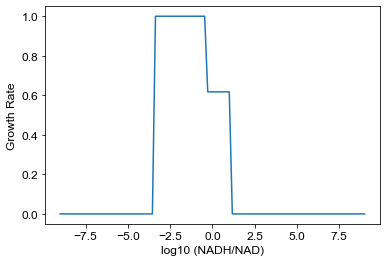

In [333]:
    
lb = 1e-6
ub = 1e-2
nad = 1
nadh_values = np.logspace(-9,9,100)
deltaG_df = pd.read_csv('../assets/deltaG.iJO1366.eQuilibiatorAPI.pH7p4.298,15T.IS0,25M.csv').set_index('rn')
#deltaG = deltaG_df.loc[reaction].deltaG_prime_m
results = {'nadh/nad':[],'max_growth_rate':[]}
for nadh in nadh_values:
    for reaction in reaction_list:
        # only if a reaction is coezyme coupled"
        mets = [x.id for x in m.reactions.get_by_id(reaction + '[condensed]').metabolites]
        if ('nad_c' in mets) & ('nadh_c' in mets):
            rn_df = parse_reaction_to_df(m.reactions.get_by_id(reaction + '[condensed]'))
            rn_df.set_index('met_id',inplace=True)
            if reaction in deltaG_df.index.get_level_values(0):
                deltaG = deltaG_df.loc[reaction].deltaG_prime_m
                res = compute_min_max_driving_force(rn_df,lb,ub,nad,nadh,deltaG)
                # define upper and lower bound on model
                if res['deltaG_min'] > 0:
                    m.reactions.get_by_id(reaction + '[condensed]').upper_bound = 0
                else:
                    m.reactions.get_by_id(reaction + '[condensed]').upper_bound = 1000

                if res['deltaG_max'] < 0:
                    m.reactions.get_by_id(reaction + '[condensed]').lower_bound = 0
                else:
                    m.reactions.get_by_id(reaction + '[condensed]').lower_bound = -1000

                #print('adjusted bounds for : ' + reaction + '[condensed]')
    objective = m.slim_optimize()
    results['max_growth_rate'].append(objective)
    results['nadh/nad'].append(nadh/nad)
    
results = pd.DataFrame(results)
results['log10 (NADH/NAD)'] = np.log10(results['nadh/nad'])
results['log10 (NADH/NAD)'] = np.log10(results['nadh/nad'])
results['Growth Rate']  = results['max_growth_rate'] / results['max_growth_rate'].max()
sns.lineplot(x='log10 (NADH/NAD)',y='Growth Rate',data=results)


In [18]:
10**(-1)

0.1

In [310]:
nadp_ratio  = np.log10(get_concentrations('bigg.metabolite:nadph',1) /get_concentrations('bigg.metabolite:nadp',1))
nad_ratio  = np.log10(get_concentrations('bigg.metabolite:nadh',1) /get_concentrations('bigg.metabolite:nad',1))

In [324]:
get_concentrations('bigg.metabolite:nadph',1) /get_concentrations('bigg.metabolite:nadp',1)

57.14285714285715

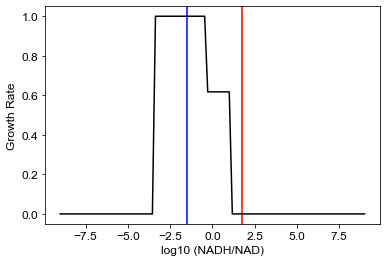

In [320]:
sns.lineplot(x='log10 (NADH/NAD)',y='Growth Rate',data=results,color='k')
plt.vlines(nadp_ratio,-0.2,1.2,colors='r')
plt.vlines(nad_ratio,-0.2,1.2,colors='b')

plt.ylim([-0.05,1.05])
plt.savefig('singleCoenzymeRedoxPotential_scan.mr4.nadRatios.svg')

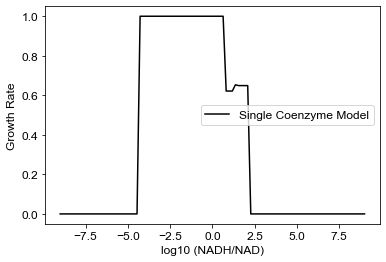

In [304]:
sns.lineplot(x='log10 (NADH/NAD)',y='Growth Rate',data=results,color='k')
#sns.scatterplot(x='log10 (NADH/NAD)',y='Growth Rate',data=results,color='k')
plt.legend(['Single Coenzyme Model'])
plt.savefig('singleCoenzymeRedoxPotential_scan.svg')

In [290]:
nadh = 1e-4
reaction = 'PERD'
deltaG = deltaG_df.loc[reaction].deltaG_prime_m
res = compute_min_max_driving_force(rn_df,lb,ub,nad,nadh,deltaG)

<AxesSubplot:xlabel='log10 (NADH/NAD)', ylabel='Growth Rate'>

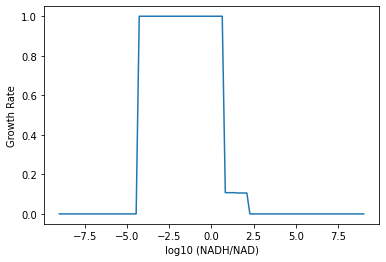

In [293]:
m_an = m.copy()
m_an.exchanges.get_by_id('EX_o2_e').lower_bound = 0

lb = 1e-6
ub = 1e-1
nad = 1
nadh_values = np.logspace(-9,9,100)
deltaG_df = pd.read_csv('../assets/deltaG.iJO1366.eQuilibiatorAPI.pH7p4.298,15T.IS0,25M.csv').set_index('rn')
#deltaG = deltaG_df.loc[reaction].deltaG_prime_m
results_an = {'nadh/nad':[],'max_growth_rate':[]}
for nadh in nadh_values:
    for reaction in reaction_list:
        # only if a reaction is coezyme coupled"
        mets = [x.id for x in m_an.reactions.get_by_id(reaction + '[condensed]').metabolites]
        if ('nad_c' in mets) & ('nadh_c' in mets):
            rn_df = parse_reaction_to_df(m_an.reactions.get_by_id(reaction + '[condensed]'))
            rn_df.set_index('met_id',inplace=True)
            if reaction in deltaG_df.index.get_level_values(0):
                deltaG = deltaG_df.loc[reaction].deltaG_prime_m
                res = compute_min_max_driving_force(rn_df,lb,ub,nad,nadh,deltaG)
                # define upper and lower bound on model
                if res['deltaG_min'] > 0:
                    m_an.reactions.get_by_id(reaction + '[condensed]').upper_bound = 0
                else:
                    m_an.reactions.get_by_id(reaction + '[condensed]').upper_bound = 1000

                if res['deltaG_max'] < 0:
                    m_an.reactions.get_by_id(reaction + '[condensed]').lower_bound = 0
                else:
                    m_an.reactions.get_by_id(reaction + '[condensed]').lower_bound = -1000

                #print('adjusted bounds for : ' + reaction + '[condensed]')

    objective = m_an.slim_optimize()
    results_an['max_growth_rate'].append(objective)
    results_an['nadh/nad'].append(nadh/nad)
    
results_an = pd.DataFrame(results_an)
results_an['log10 (NADH/NAD)'] = np.log10(results_an['nadh/nad'])
results_an['log10 (NADH/NAD)'] = np.log10(results_an['nadh/nad'])
results_an['Growth Rate']  = results_an['max_growth_rate'] / results_an['max_growth_rate'].max()
sns.lineplot(x='log10 (NADH/NAD)',y='Growth Rate',data=results_an)